In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable


from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from data import SwitchData

from torch import optim
from torch.optim import lr_scheduler


from tools import stochasticSimulation, derive_regimes, solve_ivp_discrete, \
                    smooth_dap, sol_ivp_wrapper, smooth_regime, cost, sigmoid


from networks.dense_nets import simpleNet
%load_ext autoreload
%autoreload 2

In [31]:
# Create training data set
batch_size = 3
dset = SwitchData('results/sim_history/history_01-01-2013_30_days_seed_1234')
train_loader = DataLoader(dset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True  # CUDA only
                          )


# Create test data set
batch_size_pred = 3
dtest = SwitchData('results/sim_history/history_01-08-2013_30_days_seed_1234')


test_loader = DataLoader(dtest,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True  # CUDA only
                              )

In [32]:
dset.__len__()

30

In [33]:
x, y = train_loader.dataset[0]
y

tensor([0.5017, 0.4984, 0.4307, 0.5761, 0.7084, 0.9102, 0.8683, 0.8058, 0.7625,
        0.8610])

In [49]:
# Network settings
learning_rate = 0.001
model = simpleNet()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.0)  # n
scheduler_model = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0)

# loss function
criterion = nn.MSELoss(reduction='mean')

In [50]:
# Train network
max_epochs = 200
losses = []
it = 0
for i in range(max_epochs):
    loss_ = 0.
    predicted = []
    gt = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #data = Variable(data.permute(0, 2, 1)).contiguous()
        target = Variable(target.unsqueeze_(0))
        optimizer.zero_grad()
        if target.data.size()[1] == batch_size:
            output = model(data)
            loss = criterion(output, target[0])
            loss_ += loss.data
            loss.backward()
            optimizer.step()
            for k in range(batch_size):
                predicted.append(output.data[k, 0])
                gt.append(target.data[:, k, 0])
        it += 1

    print("Epoch = ", i)
    print("Loss = ", loss_)
    losses.append(loss_)
    #writer.add_scalar("loss_epoch", loss_, i)

    scheduler_model.step()

Epoch =  0
Loss =  tensor(1.2724)
Epoch =  1
Loss =  tensor(1.0332)
Epoch =  2
Loss =  tensor(0.8470)
Epoch =  3
Loss =  tensor(0.7923)
Epoch =  4
Loss =  tensor(0.7582)
Epoch =  5
Loss =  tensor(0.7251)
Epoch =  6
Loss =  tensor(0.6946)
Epoch =  7
Loss =  tensor(0.6714)
Epoch =  8
Loss =  tensor(0.6594)
Epoch =  9
Loss =  tensor(0.6344)
Epoch =  10
Loss =  tensor(0.6173)
Epoch =  11
Loss =  tensor(0.6035)
Epoch =  12
Loss =  tensor(0.5927)
Epoch =  13
Loss =  tensor(0.5811)
Epoch =  14
Loss =  tensor(0.5748)
Epoch =  15
Loss =  tensor(0.5606)
Epoch =  16
Loss =  tensor(0.5508)
Epoch =  17
Loss =  tensor(0.5407)
Epoch =  18
Loss =  tensor(0.5314)
Epoch =  19
Loss =  tensor(0.5225)
Epoch =  20
Loss =  tensor(0.5153)
Epoch =  21
Loss =  tensor(0.5103)
Epoch =  22
Loss =  tensor(0.5035)
Epoch =  23
Loss =  tensor(0.4979)
Epoch =  24
Loss =  tensor(0.4903)
Epoch =  25
Loss =  tensor(0.4849)
Epoch =  26
Loss =  tensor(0.4796)
Epoch =  27
Loss =  tensor(0.4734)
Epoch =  28
Loss =  tensor(0.4

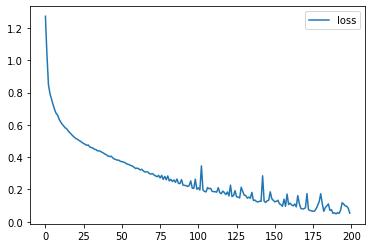

In [51]:
h = plt.figure()
x = range(len(losses))
plt.plot(x, np.array(losses), label="loss")
plt.legend()
plt.show()

In [52]:
# Predictions
predictions = []
for batch_idx, (data, target) in enumerate(test_loader):
    #data = Variable(data.permute(0, 2, 1)).contiguous()
    target = Variable(target.unsqueeze_(1))
    if target.data.size()[0] == batch_size_pred:
        output = model(data)
        
        
        for k in range(batch_size_pred):
            predictions.append(output.data[k])
            
pred_normalized = np.array([np.array(predictions[i]) for i in range(30)])
preds = dtest.scaler_test.inverse_transform(np.array(pred_normalized))

# Compare predictions and ground truth

In [53]:
day = 0
gt = dtest.history['SWITCHES']
gt[day],preds[day]

(array([ 551.57601709,  785.06670321,  796.21705481, 1260.65588834,
        1791.67326059, 2246.33032738, 2261.8327211 , 2309.3918713 ,
        2522.68598806, 2759.44133861]),
 array([ 216.35384,  207.99887,  754.63116, 1093.9205 , 1312.0068 ,
        1439.4288 , 1724.753  , 2038.0193 , 2091.0117 , 2482.1802 ],
       dtype=float32))

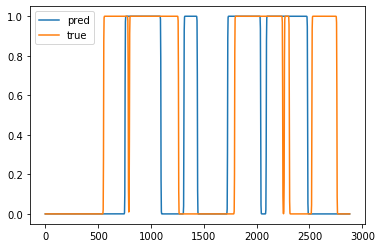

In [54]:
tplot = np.linspace(0,48*60,1000)
regime_pred = smooth_regime(tplot,preds[day])
regime_true = smooth_regime(tplot,gt[day])
plt.plot(tplot,regime_pred,label = 'pred')
plt.plot(tplot,regime_true,label = 'true')
plt.legend()